In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Find column names in measurement table
inspector = inspect(engine)
columns = inspector.get_columns("measurement")
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Find column names in station table
inspector = inspect(engine)
columns = inspector.get_columns("station")
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [12]:
# Calculate number of rows to verify next step
session.query(func.count(Measurement.date)).\
    filter(Measurement.date >= (dt.date(2017,8,23) - dt.timedelta(days=365))).all()

[(2230)]

(array([-500.,    0.,  500., 1000., 1500., 2000., 2500.]),
 <a list of 7 Text xticklabel objects>)

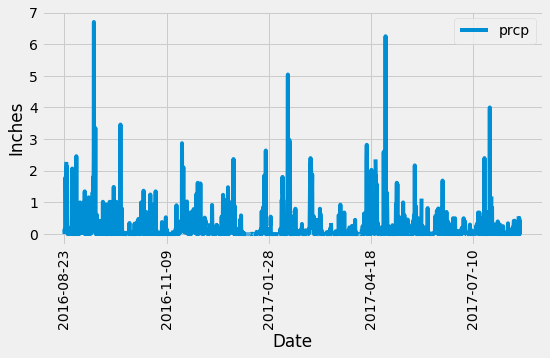

In [45]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Find the last date of precipitation data
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date
# last_date = 2017-08-23

# Calculate the date 1 year ago from the last data point in the database
one_year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
one_year_ago
# one_year_ago = 2016-08-23

# Perform a query to retrieve the data and precipitation scores
# Find the last 12 months of data based on the last date recorded
prcp_year = session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date >= (dt.date(2017,8,23) - dt.timedelta(days=365))).\
    order_by(Measurement.date.asc()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
prcp_df = pd.DataFrame(prcp_year)
prcp_df = prcp_df.set_index("date").sort_index(ascending=True)
prcp_df

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(figsize=(8,4))
plt.xlabel("Date")
plt.ylabel("Inches")
plt.xticks(rotation=90)
# plt.legend("precipitation")


In [52]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [54]:
# Check number of NaN values to verify calculation above
# i.e. number of NaN + count from summary stats = number of rows (2230)
prcp_df.isna().sum() + 2021

prcp    2230
dtype: int64

In [ ]:
# Design a query to show how many stations are available in this dataset

#MAKE THIS A COUNT:
session.query(func.distinct(Measurement.station)).\
    filter(Measurement.date >= (dt.date(2017,8,23) - dt.timedelta(days=365))).all()

In [129]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
# session.query(Measurement.station, func.distinct(Measurement.station)).group_by(Measurement.station).order_by(Measurement.station.desc()).all()

session.query(Measurement.station, func.distinct(Measurement.station)).\
    filter(Measurement.date >= (dt.date(2017,8,23) - dt.timedelta(days=365)).\
    group_by(Measurement.station).\
    order_by(Measurement.station.desc()).all()

SyntaxError: unexpected EOF while parsing (<ipython-input-129-4131f4f03a11>, line 8)

In [118]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Measurement.station == "USC00519281").all()

[(54.0, 85.0, 71.66378066378067)]

In [105]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Find station with the highest number of temp observations
session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(Measurement.station.desc()).all()

# tobs_year = session.query(Measurement.date,Measurement.tobs).\
#     filter(Measurement.date >= (dt.date(2017,8,23) - dt.timedelta(days=365))).\
#     order_by(Measurement.date.asc()).all()

# # Save the query results as a Pandas DataFrame and set the index to the date column
# # Sort the dataframe by date
# tobs_df = pd.DataFrame(tobs_year)
# tobs_df = tobs_df.set_index("date").sort_index(ascending=True)
# tobs_df

# # Plot the results as a histogram
# tobs_df.hist(figsize=(8,4))
# plt.xlabel("Date")
# plt.ylabel("Temp")
# # plt.legend("precipitation")

[('USC00519523', 2669),
 ('USC00519397', 2724),
 ('USC00519281', 2772),
 ('USC00518838', 511),
 ('USC00517948', 1372),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00513117', 2709),
 ('USC00511918', 1979)]

## Bonus Challenge Assignment

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [27]:
# Plot the daily normals as an area plot with `stacked=False`
